In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data  
import numpy as np    
from PIL import Image
import os
import matplotlib.pyplot as plt

In [2]:
IMG_SIZE = 80
BATCH_SIZE = 15
EPOCH = 2

# Load training images

In [3]:
DIR = 'C:/Users/ADMIN/Desktop/200 cats, 200 dogs'

In [4]:
fileNo = 0
for fname in os.listdir(DIR):
    fileNo = fileNo +1
    fname_with_path = DIR + '/' + fname
    img = Image.open(fname_with_path).resize((IMG_SIZE, IMG_SIZE)) 
    tensor = torch.from_numpy(np.array(img))
    tensor = tensor.view(1, IMG_SIZE, IMG_SIZE, 3)
    if(fileNo == 1):
        train_x = tensor
    else:
        train_x = torch.cat((train_x, tensor), 0)

In [5]:
train_x = train_x.type(torch.FloatTensor)

In [6]:
train_x.shape

torch.Size([400, 80, 80, 3])

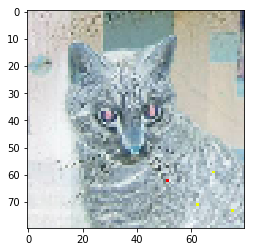

In [7]:
plt.imshow(train_x[0].numpy())

# Expand input tensor from 80x80x3 to 19200

In [8]:
train_x = train_x.view(400, 19200)

In [9]:
train_x.shape

torch.Size([400, 19200])

In [10]:
test = train_x[0]

In [11]:
test = test.view(80, 80, 3) # try to convert back from 1D to 2D array

In [12]:
test.shape

torch.Size([80, 80, 3])

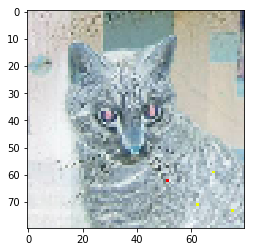

In [13]:
plt.imshow(test.numpy())

# Build tensor data set and data loader 

In [14]:
torch_dataset = Data.TensorDataset(data_tensor=train_x, target_tensor=train_x)

In [15]:
loader = Data.DataLoader(
    dataset=torch_dataset,     # torch TensorDataset format
    batch_size=BATCH_SIZE,       # mini batch size
    shuffle=True,               # random shuffle for training
    num_workers=2,              # subprocesses for loading data
)

# Define and build Autoencoder

In [16]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(19200, 9000),
            nn.BatchNorm1d(9000),
            nn.Tanh(),
            nn.Linear(9000, 5000),
            nn.BatchNorm1d(5000),
            nn.Tanh(),
            nn.Linear(5000, 2000),
            nn.BatchNorm1d(2000),
            nn.Tanh(),
            nn.Linear(2000, 500),
            nn.BatchNorm1d(500),
            nn.Tanh(),
            nn.Linear(500, 2),   # compress to 2 features which can be visualized in plt
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 500),
            nn.BatchNorm1d(500),
            nn.Tanh(),
            nn.Linear(500, 2000),
            nn.BatchNorm1d(2000),
            nn.Tanh(),
            nn.Linear(2000, 5000),
            nn.BatchNorm1d(5000),
            nn.Tanh(),
            nn.Linear(5000, 9000),
            nn.BatchNorm1d(9000),
            nn.Tanh(),
            nn.Linear(9000, 19200)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [17]:
autoencoder = AutoEncoder()

In [18]:
autoencoder

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=19200, out_features=9000, bias=True)
    (1): BatchNorm1d(9000, eps=1e-05, momentum=0.1, affine=True)
    (2): Tanh()
    (3): Linear(in_features=9000, out_features=5000, bias=True)
    (4): BatchNorm1d(5000, eps=1e-05, momentum=0.1, affine=True)
    (5): Tanh()
    (6): Linear(in_features=5000, out_features=2000, bias=True)
    (7): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True)
    (8): Tanh()
    (9): Linear(in_features=2000, out_features=500, bias=True)
    (10): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True)
    (11): Tanh()
    (12): Linear(in_features=500, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=500, bias=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True)
    (2): Tanh()
    (3): Linear(in_features=500, out_features=2000, bias=True)
    (4): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True)
    (5): Tanh()
    (6)

In [19]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)

In [20]:
loss_func = nn.MSELoss()

# Run one training epoc

In [21]:
for step, (batch_x, batch_y) in enumerate(loader): 
    break

In [22]:
print(step, batch_x.shape, batch_y.shape)

0 torch.Size([15, 19200]) torch.Size([15, 19200])


In [23]:
batch_x = Variable(batch_x) 

In [24]:
encoded, decoded = autoencoder(batch_x)

In [25]:
encoded.shape

torch.Size([15, 2])

In [26]:
decoded.shape

torch.Size([15, 19200])

# Visualize decoded result from one epoc

In [27]:
original = batch_x[0].view(80, 80, 3)

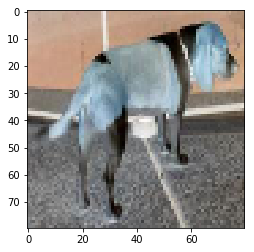

In [28]:
plt.imshow(original.data)

In [29]:
d = decoded[0]

In [30]:
d = (d-d.min())/(d.max()-d.min()) # convert values to 0~1

In [31]:
d = d*255  # convert values to 0~255

In [32]:
d = d.view(80, 80, 3)

In [33]:
ImgArray = d.data.numpy()

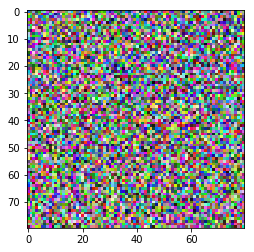

In [34]:
plt.imshow(ImgArray)

# Run loops of epocs

In [ ]:
losslst = []
for epoch in range(3):
    for step, (batch_x, batch_y) in enumerate(loader):
        batch_x = Variable(batch_x)
        batch_y = Variable(batch_y)
        encoded, decoded = autoencoder(batch_x)
            
        # calculate loss and conduct back propagation
        loss = loss_func(decoded, batch_y)      
        print('Epoch: ', epoch, '| step: ', step, '| train loss: ', loss.data.numpy()[0])
        losslst.append(loss.data.numpy()[0])
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients
    epoch = epoch + 1

# Pass data to the tained NN to visualize results

In [ ]:
encoded, decoded = autoencoder(train_x)

In [ ]:
plt.figure(figsize=(18,9)) # set the figure size to 18 x 9 inches
plt.scatter(encoded.data.numpy()[:, 0], encoded.data.numpy()[:, 1], s=100, lw=0)
plt.show()

In [ ]:
fig = plt.figure(figsize=(18, 18)) # 18x9 inches to fit 3 rows * 2 columns subplots
sub = 0 # sub graph index
for i in range(0, 3):
    sub +=1
    a=fig.add_subplot(3, 2, sub) # we have a 3 rows * 2 columns subplots
    original = train_x[i].view(80, 80, 3)
    plt.imshow(original.data)

    sub +=1
    a=fig.add_subplot(3, 2, sub)
    d = decoded[i].view(80, 80, 3)
    d = d.data
    d = (d-d.min())/(d.max()-d.min()) 
    plt.imshow(d)
    
plt.show()